**Applying RNN to Time-Series Data**

Taking weather forecasting data

In [1]:
!pip install tensorflow==2.15

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip      # Loading the data for applying RNN
!unzip jena_climate_2009_2016.csv.zip

--2024-07-20 00:23:38--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.95.29, 16.182.66.216, 52.216.164.197, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.95.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.8MB/s    in 0.7s    

2024-07-20 00:23:39 (18.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Importing the dataset

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")  # This is the file

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)     # Printing the initial values
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np
temp = np.zeros((len(lines),))
pmry_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    pmry_data[i, :] = values[:]

**Graph which shows the timeseries of temperatues as we took the weather forecasting dataset**

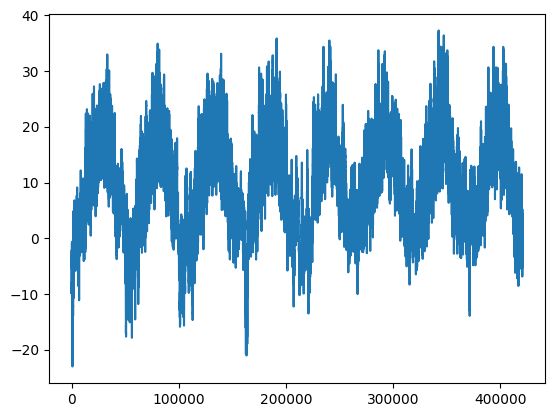

In [5]:
from matplotlib import pyplot as plt # Using matplotlib to plot the values
plt.plot(range(len(temp)), temp)

**Temperatues in °C**

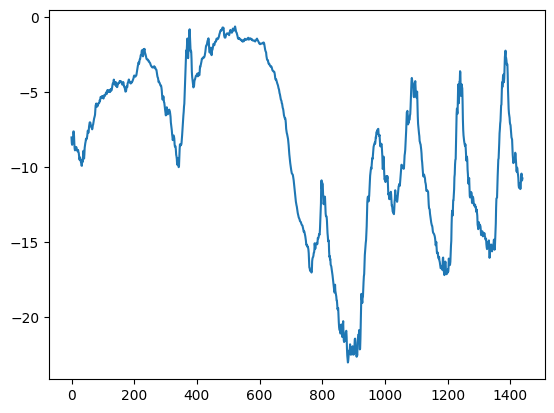

In [6]:
plt.plot(range(1440), temp[:1440])

**Calculating the quantity of samples that each data split will require**

In [7]:
num_train_samples = int(0.5 * len(pmry_data))
num_val_samples = int(0.25 * len(pmry_data))
num_test_samples = len(pmry_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Data Standardization**

Computing the mean and standard deviation on train data

In [8]:
mean = pmry_data[:num_train_samples].mean(axis=0)
pmry_data-= mean
std = pmry_data[:num_train_samples].std(axis=0)
pmry_data/= std

Here we use Numpy array to produce data sets in bulk for time series model training.

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dataset_1 = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],           # Taking input sequence of length 3
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dataset_1:     # Using for loop to iterate over batches of data
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Creating training, testing, and validation of datasets**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Shape of the data chunks**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**1st Model:**


---


***A common-sense, non-machine-learning baseline***

**Baseline MAE caluculation**

In [12]:
def evaluate_naive_method(dataset): # using evaluate_naive_method to calculate MAE
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") # Displaying the validation MAE
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}") #  # Displaying the validation MAE

Validation MAE: 2.44
Test MAE: 2.62


**2nd Model:**


---


***Basic machine-learning model***

**Simple neural network model for forecasting using Keras.**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 55s 66ms/step - loss: 12.7710 - mae: 2.7649 - val_loss: 12.9682 - val_mae: 2.8617
Epoch 2/5
819/819 [==============================] - 54s 65ms/step - loss: 9.2414 - mae: 2.3954 - val_loss: 11.9833 - val_mae: 2.7363
Epoch 3/5
819/819 [==============================] - 48s 58ms/step - loss: 8.4763 - mae: 2.2905 - val_loss: 10.7080 - val_mae: 2.5857
Epoch 4/5
819/819 [==============================] - 56s 68ms/step - loss: 7.9824 - mae: 2.2231 - val_loss: 10.4120 - val_mae: 2.5644
Epoch 5/5
405/405 [==============================] - 19s 44ms/step - loss: 11.4094 - mae: 2.6803
Test MAE: 2.68


The above model takes as input a sequence of data points and outputs a single value.

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 49s 59ms/step - loss: 21.3422 - mae: 3.5451 - val_loss: 13.0180 - val_mae: 2.8370
Epoch 2/5
819/819 [==============================] - 51s 62ms/step - loss: 12.0865 - mae: 2.7537 - val_loss: 11.6640 - val_mae: 2.6727
Epoch 3/5
819/819 [==============================] - 52s 63ms/step - loss: 11.2515 - mae: 2.6555 - val_loss: 11.6767 - val_mae: 2.6798
Epoch 4/5
819/819 [==============================] - 57s 69ms/step - loss: 10.7244 - mae: 2.5885 - val_loss: 12.6861 - val_mae: 2.7898
Epoch 5/5
405/405 [==============================] - 18s 42ms/step - loss: 11.2767 - mae: 2.6148
Test MAE: 2.61


In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 54s 65ms/step - loss: 12.4065 - mae: 2.7281 - val_loss: 16.1670 - val_mae: 3.2094
Epoch 2/5
819/819 [==============================] - 54s 66ms/step - loss: 8.7979 - mae: 2.3292 - val_loss: 12.2740 - val_mae: 2.7605
Epoch 3/5
819/819 [==============================] - 50s 60ms/step - loss: 7.8028 - mae: 2.1974 - val_loss: 11.5608 - val_mae: 2.6933
Epoch 4/5
819/819 [==============================] - 53s 64ms/step - loss: 7.2062 - mae: 2.1142 - val_loss: 12.0734 - val_mae: 2.7553
Epoch 5/5
405/405 [==============================] - 16s 40ms/step - loss: 11.4883 - mae: 2.6866
Test MAE: 2.69


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 57s 68ms/step - loss: 12.7053 - mae: 2.7574 - val_loss: 18.0272 - val_mae: 3.3856
Epoch 2/5
819/819 [==============================] - 53s 64ms/step - loss: 8.4730 - mae: 2.2866 - val_loss: 10.5666 - val_mae: 2.5640
Epoch 3/5
819/819 [==============================] - 55s 67ms/step - loss: 7.3854 - mae: 2.1380 - val_loss: 12.5138 - val_mae: 2.8001
Epoch 4/5
819/819 [==============================] - 56s 68ms/step - loss: 6.6785 - mae: 2.0325 - val_loss: 10.4335 - val_mae: 2.5578
Epoch 5/5
405/405 [==============================] - 17s 40ms/step - loss: 11.5738 - mae: 2.6986
Test MAE: 2.70


Tried various dense units of 8, 32 and 64

**Graph of Training and Validation MAE Values**

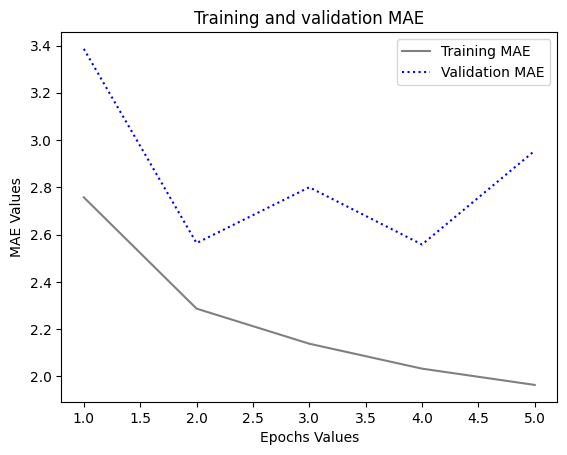

In [18]:
# matplotlib.pyplot for creating plots
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**3rd Model:**


---



***1D convolutional model***

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))
convol_x = layers.Conv1D(8, 24, activation="relu")(inputs)     # 1D conventional layer
convol_x = layers.MaxPooling1D(2)(convol_x)                    # Max pooling Layer
convol_x = layers.Conv1D(8, 12, activation="relu")(convol_x)   # 1D conventional layer
convol_x = layers.MaxPooling1D(2)(convol_x)                    # Max pooling Layer
convol_x = layers.Conv1D(8, 6, activation="relu")(convol_x)    # 1D conventional layer
convol_x = layers.GlobalAveragePooling1D()(convol_x)
outputs = layers.Dense(1)(convol_x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.convol_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.convol_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 85s 103ms/step - loss: 23.3811 - mae: 3.7902 - val_loss: 15.8301 - val_mae: 3.1200
Epoch 2/5
819/819 [==============================] - 88s 107ms/step - loss: 16.3592 - mae: 3.2140 - val_loss: 16.7277 - val_mae: 3.2555
Epoch 3/5
819/819 [==============================] - 81s 98ms/step - loss: 14.8700 - mae: 3.0597 - val_loss: 14.9142 - val_mae: 3.0677
Epoch 4/5
819/819 [==============================] - 85s 104ms/step - loss: 14.0818 - mae: 2.9770 - val_loss: 19.2458 - val_mae: 3.5169
Epoch 5/5
405/405 [==============================] - 22s 53ms/step - loss: 16.2532 - mae: 3.2151
Test MAE: 3.22


We received

Validation MAE: 3.2278

Test MAE      : 3.20

**Graph of Training and Validation MAE Values**

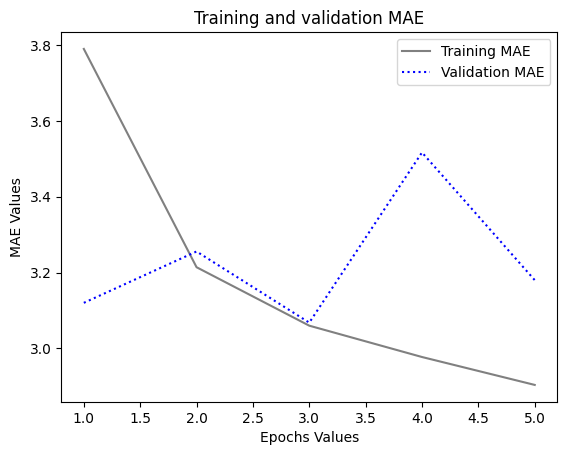

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

The first recurrent baseline

**4th Model:**


---



***Simple LSTM-based model***

In [22]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 123s 141ms/step - loss: 41.6451 - mae: 4.6872 - val_loss: 12.0561 - val_mae: 2.6358
Epoch 2/5
819/819 [==============================] - 109s 132ms/step - loss: 10.8549 - mae: 2.5551 - val_loss: 9.6153 - val_mae: 2.4022
Epoch 3/5
819/819 [==============================] - 108s 131ms/step - loss: 9.5623 - mae: 2.4072 - val_loss: 9.5242 - val_mae: 2.3899
Epoch 4/5
819/819 [==============================] - 104s 126ms/step - loss: 9.1359 - mae: 2.3506 - val_loss: 9.8053 - val_mae: 2.4170
Epoch 5/5
405/405 [==============================] - 26s 62ms/step - loss: 10.4601 - mae: 2.5333
Test MAE: 2.53


We received

Validation MAE: 2.3790

Test MAE      : 2.55

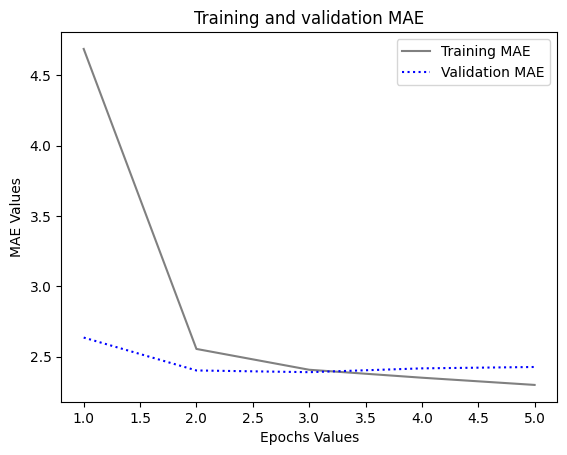

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**5th Model:**


---



***Recurrent neural networks***

**Apllying Numpy to a simple RNN**

In [24]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [25]:
num_features = 14  # Recurring network processing sequences of length
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**RNN layer returning output shape**

In [26]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [27]:
num_features = 14  # Full output sequence retrieval from an RNN layer
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking Of Recurring Neural Network**

In [28]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

**6th Model:**


---


***Recurring Neural Network(LSTM Layers)***

***Using recurrent dropout***

**Computing the dropout-regularized LSTM**

In [30]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))              # Defining the input layer of the model
lstm_x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
lstm_x = layers.Dropout(0.5)(lstm_x)  # Using droput function
outputs = layers.Dense(1)(lstm_x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.lstm_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.lstm_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the Test sample MAE

Epoch 1/5
819/819 [==============================] - 178s 209ms/step - loss: 46.8937 - mae: 5.1014 - val_loss: 14.5863 - val_mae: 2.8339
Epoch 2/5
819/819 [==============================] - 158s 193ms/step - loss: 20.0621 - mae: 3.4440 - val_loss: 10.1429 - val_mae: 2.4815
Epoch 3/5
819/819 [==============================] - 161s 196ms/step - loss: 18.3131 - mae: 3.2922 - val_loss: 9.8070 - val_mae: 2.4498
Epoch 4/5
819/819 [==============================] - 163s 199ms/step - loss: 17.4915 - mae: 3.2176 - val_loss: 9.5520 - val_mae: 2.4126
Epoch 5/5
405/405 [==============================] - 28s 66ms/step - loss: 10.9959 - mae: 2.6196
Test MAE: 2.62


We received

Validation MAE: 2.4221

Test MAE : 2.62

 **Graph of dropout-regularized LSTM displaying the validation and training MAE**

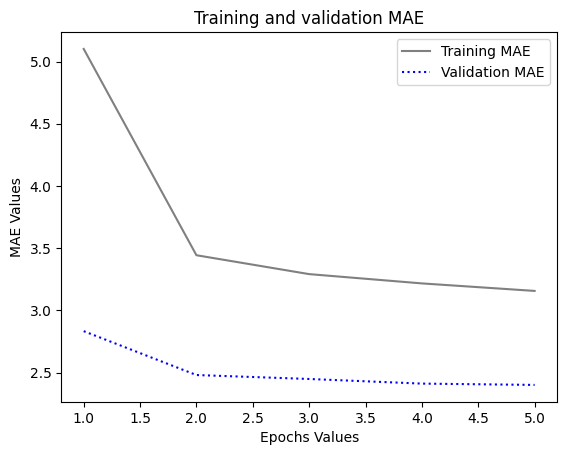

In [31]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

In [32]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.2, unroll=True)(inputs) # Using the LSTM

**7th Model:**


---



***Stacked setup of recurrent layers***

**Computing dropout-regularized, stacked GRU model**

In [33]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))      # Defining the input layer of the model
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")  # Printing the MAE for test dataset

Epoch 1/5
819/819 [==============================] - 342s 409ms/step - loss: 25.0365 - mae: 3.6913 - val_loss: 9.3038 - val_mae: 2.3669
Epoch 2/5
819/819 [==============================] - 335s 409ms/step - loss: 13.9876 - mae: 2.8940 - val_loss: 9.0036 - val_mae: 2.3246
Epoch 3/5
819/819 [==============================] - 328s 400ms/step - loss: 13.1691 - mae: 2.8120 - val_loss: 9.3621 - val_mae: 2.3769
Epoch 4/5
819/819 [==============================] - 336s 410ms/step - loss: 12.5251 - mae: 2.7454 - val_loss: 8.9028 - val_mae: 2.3124
Epoch 5/5
405/405 [==============================] - 42s 100ms/step - loss: 9.6172 - mae: 2.4305
Test MAE: 2.43


We received

Validation MAE: 2.3444

Test MAE : 2.46

**8th Model:**


---


***Bidirectional RNN***

**Computing the Bidirectional LSTM**

In [34]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)                    # Using the Bidirectional function for the model
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")    # Printing The Testing dataset MAE

Epoch 1/5
819/819 [==============================] - 155s 176ms/step - loss: 24.8898 - mae: 3.6092 - val_loss: 10.4713 - val_mae: 2.5081
Epoch 2/5
819/819 [==============================] - 148s 180ms/step - loss: 9.4318 - mae: 2.3997 - val_loss: 9.4660 - val_mae: 2.3867
Epoch 3/5
819/819 [==============================] - 156s 190ms/step - loss: 8.5433 - mae: 2.2765 - val_loss: 9.8383 - val_mae: 2.4336
Epoch 4/5
819/819 [==============================] - 146s 178ms/step - loss: 8.0306 - mae: 2.2068 - val_loss: 10.1170 - val_mae: 2.4812
Epoch 5/5
405/405 [==============================] - 36s 88ms/step - loss: 10.8439 - mae: 2.6016
Test MAE: 2.60


We received

Validation MAE: 2.5226

Test MAE : 2.60

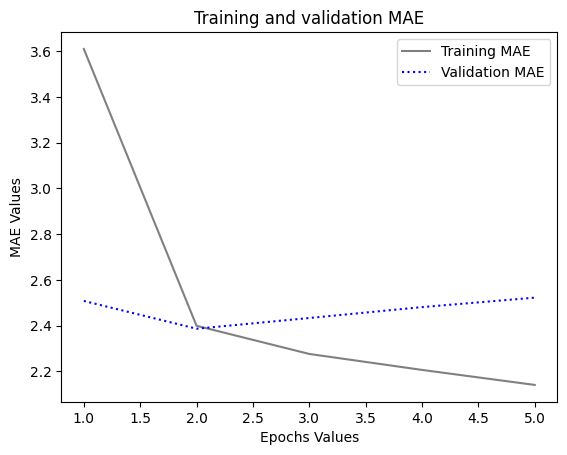

In [35]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**9th Model:**


---


***Combination Of 1D convent and dropout-regularized LSTM***

In [36]:
mix_1d_RNN = layers.concatenate([convol_x, lstm_x]) # Using 1D convent and RNN
outputs = layers.Dense(1)(mix_1d_RNN)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}") # Printing the Testing MAE

Epoch 1/5
819/819 [==============================] - 152s 179ms/step - loss: 7.1739 - mae: 2.0866 - val_loss: 10.8697 - val_mae: 2.5682
Epoch 2/5
819/819 [==============================] - 156s 190ms/step - loss: 6.9490 - mae: 2.0546 - val_loss: 10.8731 - val_mae: 2.5632
Epoch 3/5
819/819 [==============================] - 147s 180ms/step - loss: 6.6829 - mae: 2.0148 - val_loss: 11.1720 - val_mae: 2.6083
Epoch 4/5
819/819 [==============================] - 150s 182ms/step - loss: 6.4780 - mae: 1.9828 - val_loss: 11.1920 - val_mae: 2.6014
Epoch 5/5
405/405 [==============================] - 32s 77ms/step - loss: 12.4554 - mae: 2.7800
Test MAE: 2.78


We received

Validation MAE: 2.4410

Test MAE : 2.60

**Graph of Training and Validation MAE of the combination of 1D Convent and RNN**

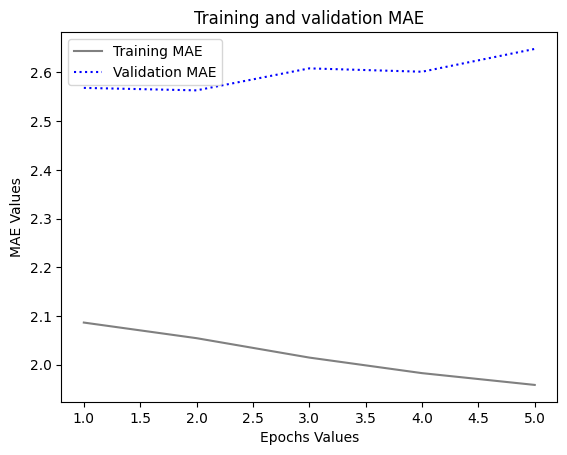

In [37]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()